# **ĐANG SUY NGHĨ XEM NÊN VIẾT CÁI GÌ ĐỂ GIỚI THIỆU**

# **Mount to Gdrive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Import requirement lib**

In [2]:
import os # used to handle files using system commands.
import pickle # used to store numpy features extracted
import numpy as np  # used to perform a wide variety of mathematical operations 
                    # on arrays
from tqdm.notebook import tqdm  # progress bar decorator for iterators. 
                                # Includes a default range iterator printing to 
                                # stderr.

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
    # imported modules for feature extraction from the image data
from tensorflow.keras.preprocessing.image import load_img, img_to_array
    # used for loading the image and converting the image to a numpy array
from tensorflow.keras.preprocessing.text import Tokenizer
    # used for loading the text as convert them into a token
from tensorflow.keras.preprocessing.sequence import pad_sequences
    # used for equal distribution of words in sentences filling the remaining 
    # spaces with zeros
from tensorflow.keras.models import Model
    # stored model
from tensorflow.keras.utils import to_categorical, plot_model
    # used to visualize the architecture of the model through different images
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
    # operation for advanced model option

# **Test Generate Captions for the Image**

## **Decode from integer to word**

In [3]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

## **Generate caption for the Image**

In [4]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  # add start tag for generation process
  in_text = 'startseq'

  # iterate over the max length of sequence
  for i in range(max_length): # max_length we got: 34
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)
    
    # append eng tag and stop if word not found
    if word is None:
      in_text += " " + 'endseq'
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

## **Prepare for Testing**

### **Load Captions with imgID**

In [5]:
with open('/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/Caption with imgID/caption_with_imgID_flickr.pkl', 'rb') as f:
    mapping = pickle.load(f)

### **Stored mapping as list**

In [6]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

### **Create a vocabulary**

In [7]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

### **Get max_length**

In [8]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

### **Load feature Img**

In [9]:
import pickle

# Load
with open('/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/Extracted feature/featured_extracted_flickr.pkl', 'rb') as f:
    features = pickle.load(f)

### **Split data**

In [10]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

### **Load model**

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [12]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Đồ án/Machine learning/Image captioning/model/best_model_15_02_2023_15Epoches.h5')

## **Testing and Evaluation**

In [13]:
def Test_and_Evaluate(model, test, features, mapping, tokenizer, max_length):

  from nltk.translate.bleu_score import corpus_bleu
  # validate with test data
  actual, predicted = list(), list()

  for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

  # calcuate BLEU score
  BLEU_1, BLEU_2 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)), \
                   corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

  return BLEU_1, BLEU_2

In [14]:
BLEU_1, BLEU_2 = Test_and_Evaluate(model, test, features, mapping, tokenizer, max_length)
print("BLEU-1: %f" % BLEU_1)
print("BLEU-2: %f" % BLEU_2)

  0%|          | 0/1619 [00:00<?, ?it/s]

BLEU-1: 0.518884
BLEU-2: 0.299402


# **Apply API key to use kaggle API cmd**

In [15]:
! mkdir ~/.kaggle

In [16]:
! cp '/content/gdrive/MyDrive/API key/kaggle.json' ~/.kaggle

In [17]:
! chmod 600 ~/.kaggle/kaggle.json

## **Search && download dataset on kaggle**

In [18]:
! kaggle datasets list --user 'adityajn105'

ref                     title                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------  ----------------------------  ----  -------------------  -------------  ---------  ---------------  
adityajn105/flickr8k    Flickr 8k Dataset              1GB  2020-04-27 07:27:19          28639        208  0.75             
adityajn105/flickr30k   Flick 30k Dataset              8GB  2020-04-27 08:07:18           1044          8  0.625            
adityajn105/glove6b50d  GLOVE 6B 50D Word Embeddings  68MB  2020-04-27 08:58:27            418          2  0.625            


In [19]:
! kaggle datasets files 'adityajn105/flickr8k'

name          size  creationDate         
------------  ----  -------------------  
captions.txt   3MB  2020-04-27 07:27:19  


In [20]:
! kaggle datasets download 'adityajn105/flickr8k' --unzip

100% 1.04G/1.04G [00:32<00:00, 37.7MB/s]
100% 1.04G/1.04G [00:32<00:00, 34.7MB/s]


In [21]:
! mkdir '/content/flickr8k'

In [22]:
! mv '/content/captions.txt' '/content/flickr8k'

In [23]:
! mv '/content/Images' '/content/flickr8k'

# **Determind DIR**

In [24]:
BASE_DIR = '/content/flickr8k'

# **Visualize the Results**

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name, BASE_DIR, mapping, model, features, tokenizer, max_length):
    # img_name: name of image we will generate caption
    # BASE_DIR: which DIR store dataset and store img we will generate caption for visualize
    # mapping: captions with imgID
    # model: model for predict caption (best model stored)
    # features: all feature of images which extracted
    # tokenizer: a vocab we get
    # max_length: maximum length of the caption available

    # load the image
    # image_name = "name.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

## **Visual some image**

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq two people are standing in front of flowers endseq


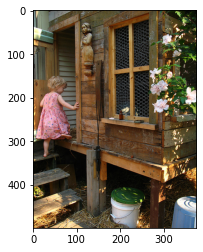

In [26]:
generate_caption('1000268201_693b08cb0e.jpg', BASE_DIR, mapping, model, features, tokenizer, max_length)

---------------------Actual---------------------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
--------------------Predicted--------------------
startseq two people are standing in the ice one is drilling endseq


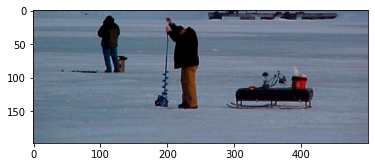

In [27]:
generate_caption('102351840_323e3de834.jpg', BASE_DIR, mapping, model, features, tokenizer, max_length)

---------------------Actual---------------------
startseq little girl looking at brochure on train rides endseq
startseq young blond girl with magizine in her hands endseq
startseq young girl on train reads book about train rides endseq
startseq young girl sits on seat and looks at train pamphlet endseq
startseq child sitting down looking at train ride brochure endseq
--------------------Predicted--------------------
startseq girl in magizine reads brochure endseq


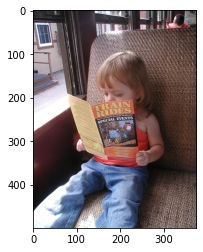

In [28]:
generate_caption('1056359656_662cee0814.jpg', BASE_DIR, mapping, model, features, tokenizer, max_length)